In [1]:
pip install https://github.com/fastai/fastai1/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/fastai/fastai1/archive/master.zip


In [2]:
# ensure that any edits to libraries you make are reloaded here automatically
%reload_ext autoreload
%autoreload 2

# ensure that any charts or images displayed are shown in this notebook
%matplotlib inline

In [3]:
from fastai.vision import * # fastai V1 library which sits on top of Pytorch 1.0
from fastai.callbacks import *
import os
import warnings # to avoid warning of PyTorch
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
import numpy as np
import pandas as pd
np.random.seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/ML-Lab/EpochLogs/Resnet'

/content/drive/.shortcut-targets-by-id/1YMtIXHBBLIQyuH_5uW3lGWVd0F0zsx9N/ML-Lab/EpochLogs/Resnet


In [6]:
# transform the data to achive data augmentation, we will see more about this later
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

In [7]:
path = '/content/drive/MyDrive/ML-Lab/Data/Original/Corpus-CorrectData'
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=299, num_workers=4, padding_mode='reflection', bs=64).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

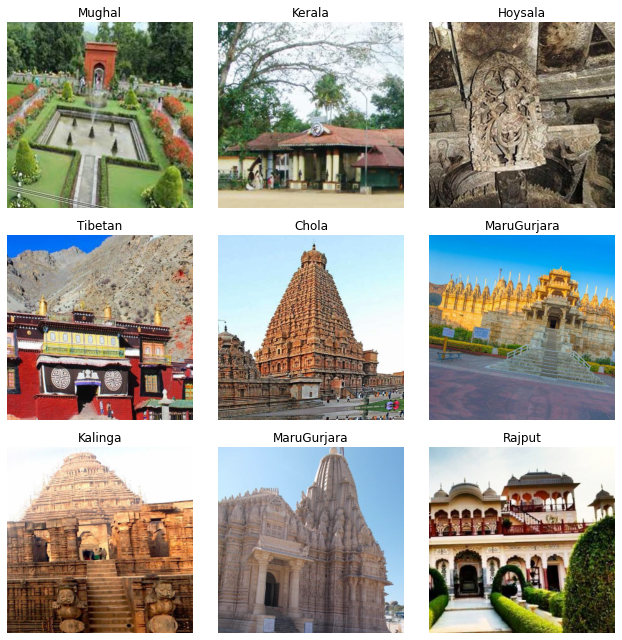

In [8]:
data.show_batch(rows=3, figsize=(9, 9))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Cave-Arch',
  'Chola',
  'Hoysala',
  'Kalinga',
  'Kerala',
  'MaruGurjara',
  'Mughal',
  'Rajput',
  'Tibetan'],
 9,
 1432,
 358)

In [10]:
def _plot(i,j,ax):
    x,y = data.train_ds[15]
    x.show(ax, y=y)

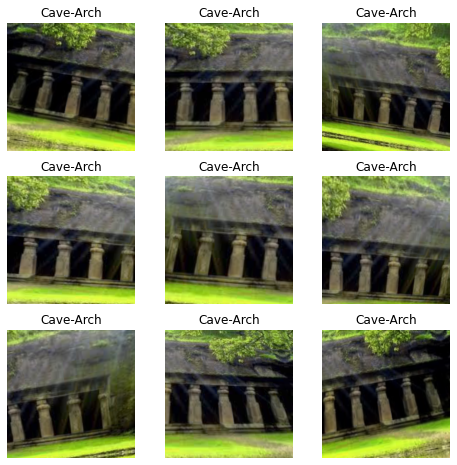

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate, Precision(), Recall()], wd=1e-1, callback_fns=[CSVLogger])
# We will train for 6 epochs (6 cycles through all our data)

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [14]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,error_rate,precision,recall,time
0,1.898766,0.760611,0.779330,0.220670,0.797898,0.774519,01:04
1,1.167564,0.747235,0.801676,0.198324,0.809113,0.795637,01:02
2,0.806762,0.547961,0.835196,0.164804,0.847235,0.833801,01:04
3,0.623260,0.469358,0.846369,0.153631,0.856076,0.844644,01:02
4,0.460727,0.415104,0.851955,0.148045,0.851828,0.850265,01:01
5,0.367969,0.405703,0.854749,0.145251,0.856508,0.852813,01:02


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [15]:
learn.save('stage-1-resnet50')

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[('Chola', 'Kalinga', 6), ('Tibetan', 'Kerala', 5), ('Rajput', 'Mughal', 3)]

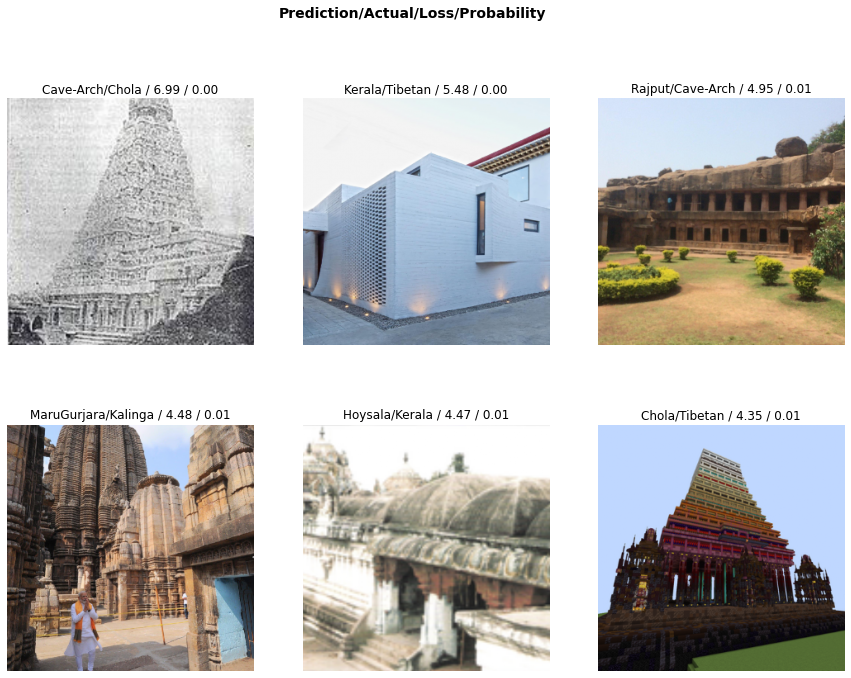

In [17]:
interp.plot_top_losses(6, figsize=(15,11))

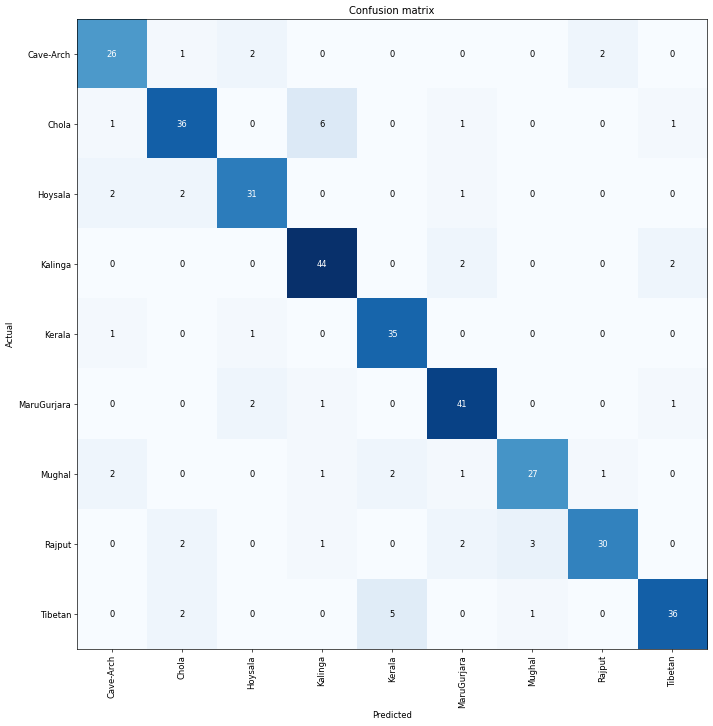

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


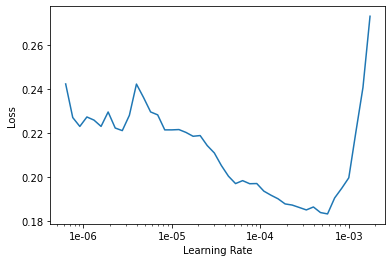

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(6, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,precision,recall,time
0,0.217916,0.484583,0.863128,0.136872,0.865186,0.863667,01:03
1,0.273999,0.810227,0.837989,0.162011,0.846704,0.842810,01:03
2,0.328515,0.746455,0.849162,0.150838,0.863112,0.849537,01:05
3,0.274372,0.584228,0.843575,0.156425,0.849140,0.845374,01:03
4,0.210292,0.366235,0.907821,0.092179,0.908831,0.906543,01:04
5,0.152888,0.337238,0.924581,0.075419,0.925023,0.923364,01:05


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
learn.save('stage-2-resnet50')

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[('Mughal', 'Rajput', 6), ('Hoysala', 'Chola', 4), ('Tibetan', 'Kerala', 3)]

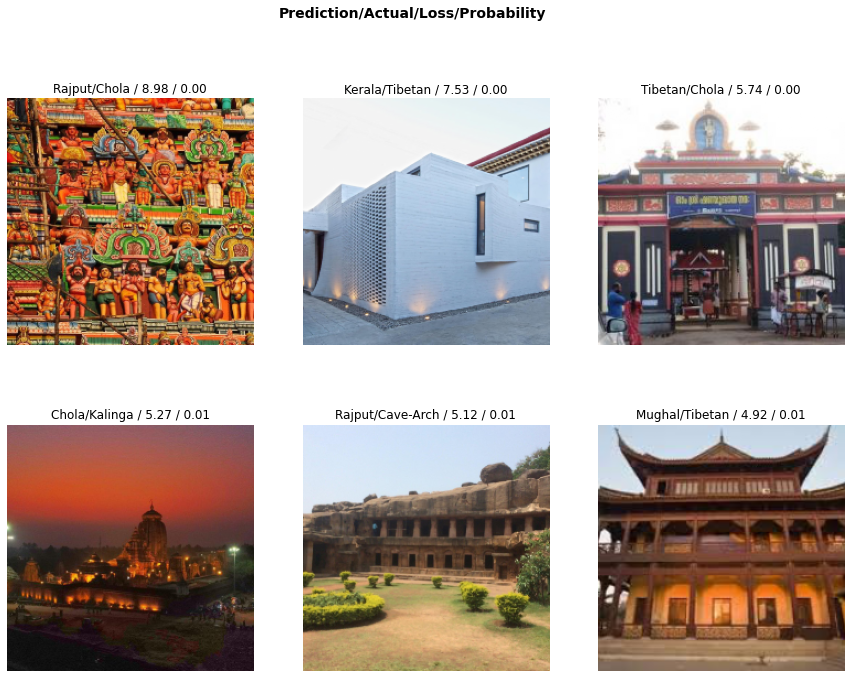

In [25]:
interp.plot_top_losses(6, figsize=(15,11))

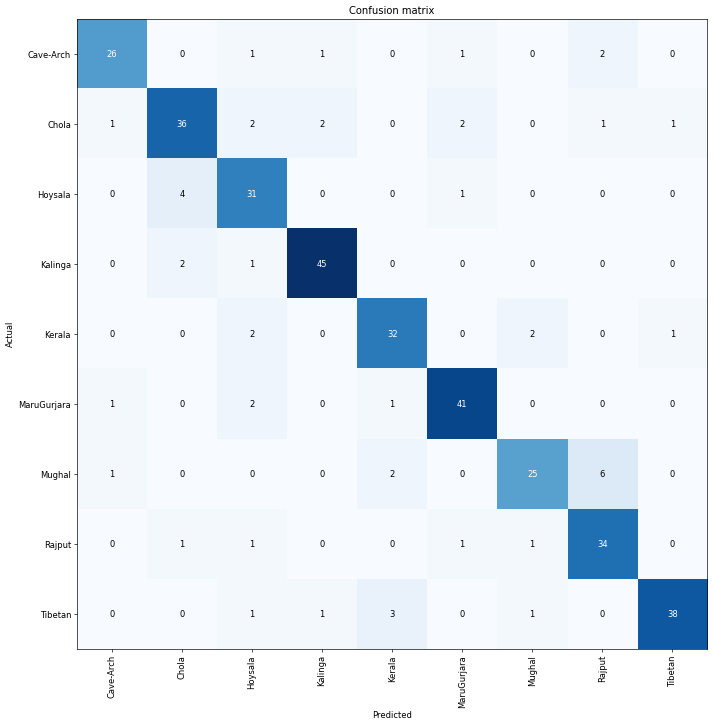

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)